In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import gamma

In [2]:
def log_interp(x,x_spec,y_spec):
    return 10**np.interp(np.log10(x),np.log10(x_spec),np.log10(y_spec));

In [3]:
def blwn(fmin,fmax,bwp,loc):  # bwp : band width percentage # loc : location percentage
    df = (fmax-fmin)*bwp;
    f1 = fmin + loc*(fmax-fmin-df);
    f2 = f1+df;
    A = (100**2) / (f2-f1)    # grms = 100
    freq = np.array([f1,f2]);
    psd = np.array([A,A]);
    return freq,psd;

In [4]:
def M(freq,psd,n):
    df = freq[1] - freq[0];
    if df > 1:
        fmin = min(freq); fmax = max(freq);
        if fmin <= 0:
            fmin = 1e-2;
        fi = np.arange(fmin,fmax+1,1);
        pi = log_interp(fi,freq,psd);
        freq,psd = fi,pi;
    psd1 = psd*freq**n;
    return np.trapz(psd1,freq);

In [5]:
def D_NB(freq,psd,m,T,C):
    M0 = M(freq,psd,0);  M2 = M(freq,psd,2);
    E0 = np.sqrt(M2/M0);
    return E0*T*((2*M0)**(m/2))*gamma(m/2+1) / C;

In [6]:
def D_WL(freq,psd,m,T,C):
    DNB = D_NB(freq,psd,m,T,C);
    M0 = M(freq,psd,0);  M2 = M(freq,psd,2);  M4 = M(freq,psd,4);
    E0 = np.sqrt(M2/M0);
    Ep = np.sqrt(M4/M2);
    r = E0/Ep;
    lam = np.sqrt(1-r**2);
    a = 0.926 - 0.033*m;
    b = 1.587*m - 2.323;
    zeta = a + (1-a)*(1-lam)**b
    return DNB*zeta;

In [7]:
def D_OC(freq,psd,m,T,C):
    DNB = D_NB(freq,psd,m,T,C);
    k = 2/m;
    M0 = M(freq,psd,0);  M2 = M(freq,psd,2);  M4 = M(freq,psd,4); Mk = M(freq,psd,k); Mk2 = M(freq,psd,k+2);
    E0 = np.sqrt(M2/M0);
    Ep = np.sqrt(M4/M2);
    r = E0/Ep;
    zeta = (1/r)*((M2*Mk)/(M0*Mk2))**(m/2);
    return DNB*zeta;

In [8]:
def D_dirlik(freq,psd,m,T,C):
    M0 = M(freq,psd,0);  M1 = M(freq,psd,1);  M2 = M(freq,psd,2);  M4 = M(freq,psd,4);
    E0 = np.sqrt(M2/M0);
    Ep = np.sqrt(M4/M2);
    r = E0/Ep;    
    Xm = (M1/M0)*np.sqrt(M2/M4);
    Z = 1/np.sqrt(M0);
    D1 = 2*(Xm-r**2)/(1+r**2);
    R = (r-Xm-D1**2)/(1-r-D1+D1**2);
    D2 = (1-r-D1+D1**2)/(1-R);
    D3 = 1 - D1 - D2;
    Q = 1.25*(r-D3-D2*R)/D1
    def f(sa):
        A1 = D1/(np.sqrt(M0)*Q);
        A2 = D2*Z*sa/(np.sqrt(M0)*R**2);
        A3 = D3*Z*sa/np.sqrt(M0);
        a1 = -Z*sa/Q
        a2 = -(Z**2)*(sa**2)/(2*R**2);
        a3 = -(Z**2)*(sa**2)/2;
        return A1*np.exp(a1) + A2*np.exp(a2) + A3*np.exp(a3);
    def z(m):
        mm = np.linspace(3,12,10);
        zz = np.array([8.652,8.822,8.982,9.133,9.277,9.415,9.546,9.673,9.796,9.915]);
        return np.interp(m,mm,zz);
    LB = 0; UB = z(m)*np.sqrt(M0);
    s = np.linspace(LB,UB,10000);
    samfsa = (s**m)*f(s);
    intsamfsa = np.trapz(samfsa,s);
    return Ep*T*intsamfsa/C;

In [9]:
def H(f,fn,zeta):   # Input : Acceleration / Output : Relative Displacement
    return 386.4/(((np.pi)**2)*(fn**2-f**2+1j*2*zeta*f*fn));

In [10]:
def HH(f,fn,zeta):   # Input : Acceleration / Output : Relative Displacement
    return np.abs(H(f,fn,zeta)*np.conjugate(H(f,fn,zeta)));

In [11]:
def FDS_dirlik(fi,pi,zeta,m,T,C):
    fn = np.linspace(1,5000,5000); D = np.zeros(5000);
    for i in range(5000):
        K = 1
        rpsd = pi*HH(fi,fn[i],zeta)*K;
        D[i] = D_dirlik(fi,rpsd,m=4,T=1,C=1);
    return fn,D;

In [12]:
def band_split(fi,pi,nb): # fi : interpolated freq, ai : interpolated psd, nb : # of bands
    ni = len(fi);
    grms = np.sqrt(np.trapz(pi,fi))
    goal = grms/np.sqrt(nb);  # target grms
    idx = np.zeros(nb+1,'int');
    grms_tmp = 0;
    for i in range(1,nb):
        while(grms_tmp < goal):
            idx[i] += 1;
            grms_tmp = np.sqrt(np.trapz(pi[idx[i-1]:idx[i]],fi[idx[i-1]:idx[i]]));
        grms_tmp1 = np.sqrt(np.trapz(pi[:idx[i]+1],fi[:idx[i]+1]));
        if np.abs(grms_tmp1 - goal) < np.abs(grms_tmp - goal):
            idx[i] += 1;
        grms_tmp = 0; grms_tmp1 = 0;
    idx[0] = 0; idx[nb] = len(pi);
    dfi = []; dpi = [];
    for i in range(nb):
        dfi.append(fi[idx[i]:idx[i+1]+1]); dpi.append(pi[idx[i]:idx[i+1]+1]);
    return dfi,dpi

In [13]:
"""
# Generate Input PSD
fmin = 1; fmax = 5000; bwp = 1; loc = 0;
freq_spec,psd_spec = blwn(fmin,fmax,bwp,loc);
# Band Split
fi = np.linspace(min(freq_spec),max(freq_spec),10000);
pi = log_interp(fi,freq_spec,psd_spec);
dfi,dpi = band_split(fi,pi,2);
# Calculate FDS
fn,D = FDS_dirlik(fi,pi,zeta=0.01,m=4,T=1,C=1);
fn,D1 = FDS_dirlik(dfi[0],dpi[0],zeta=0.01,m=4,T=1,C=1);
fn,D2 = FDS_dirlik(dfi[1],dpi[1],zeta=0.01,m=4,T=1,C=1);
"""

'\n# Generate Input PSD\nfmin = 1; fmax = 5000; bwp = 1; loc = 0;\nfreq_spec,psd_spec = blwn(fmin,fmax,bwp,loc);\n# Band Split\nfi = np.linspace(min(freq_spec),max(freq_spec),10000);\npi = log_interp(fi,freq_spec,psd_spec);\ndfi,dpi = band_split(fi,pi,2);\n# Calculate FDS\nfn,D = FDS_dirlik(fi,pi,zeta=0.01,m=4,T=1,C=1);\nfn,D1 = FDS_dirlik(dfi[0],dpi[0],zeta=0.01,m=4,T=1,C=1);\nfn,D2 = FDS_dirlik(dfi[1],dpi[1],zeta=0.01,m=4,T=1,C=1);\n'

In [14]:
"""
# Plot
plt.figure(figsize=(16,16));
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
plt.subplot(321);
plt.plot(dfi[0],dpi[0],label='band1'); plt.plot(dfi[1],dpi[1],label='band2'); plt.legend();
plt.xscale('log'); plt.yscale('log'); plt.xlim(fmin,fmax); plt.title('Input PSD(BW=%.1f, loc=%.1f)'%(bwp,loc)); plt.xlabel('Freq(Hz)'); plt.ylabel('PSD(g^2/Hz)');
plt.grid(b=True, which='both', linestyle='-');
plt.subplot(322);
plt.plot(fn,D,label='original'); plt.plot(fn,D1,label='band1'); plt.plot(fn,D2,label='band2'); 
plt.xscale('log'); plt.yscale('log'); plt.legend(); plt.xlim(fmin,fmax);
plt.title('FDS'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage');
plt.grid(b=True, which='both', linestyle='-');
plt.subplot(323);
xlim1 = max(dfi[0])*0.9; xlim2 = min(dfi[1])*1.1;
ylim1 = min(D[(fn>xlim1)&(fn<xlim2)])*0.1; 
ylim2 = max(D[(fn>xlim1)&(fn<xlim2)])*10; 
plt.plot(fn,D,'k-',label='original'); plt.plot(fn,D1,'r--',label='band1'); plt.plot(fn,D2,'b--',label='band2'); 
plt.plot(fn,D1+D2,'g--',label='split(sum)');  plt.yscale('log');
plt.legend(); plt.xlim(xlim1,xlim2); plt.ylim(ylim1,ylim2);
plt.title('FDS, Near Band Split Freq');
plt.grid(b=True, which='major', linestyle='-');
plt.subplot(324);
plt.plot(fn,D,'k-',label='original'); plt.plot(fn,D1+D2,'r--',label='split(sum)');  
plt.xscale('log'); plt.yscale('log'); plt.legend(); plt.xlim(fmin,fmax);
plt.title('FDS'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage');
plt.grid(b=True, which='both', linestyle='-');
plt.subplot(325);
rD = D/(D1+D2);
plt.plot(fn,rD,'k-',label='original/split(sum)');
plt.legend(); plt.xlim(fmin,fmax);
plt.xscale('log'); plt.title('FDS Ratio(original/split(sum))'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage Ratio');
plt.grid(b=True, which='both', linestyle='-');
plt.subplot(326);
plt.plot(fn,rD,'k-',label='original/split(sum)');
ylim1 = min(rD[(fn>xlim1)&(fn<xlim2)])*0.5; ylim2 = max(rD[(fn>xlim1)&(fn<xlim2)])*2;
plt.grid(which='both'); plt.legend(); plt.xlim(xlim1,xlim2); plt.ylim(ylim1,ylim2);
plt.title('FDS Ratio(original/split(sum)), Near Band Split Freq'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage Ratio');\
plt.grid(b=True, which='both', linestyle='-');
plt.savefig('BW%.1f_LOC%.1f.png'%(bwp,loc), dpi=300); 
"""

"\n# Plot\nplt.figure(figsize=(16,16));\nplt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)\nplt.subplot(321);\nplt.plot(dfi[0],dpi[0],label='band1'); plt.plot(dfi[1],dpi[1],label='band2'); plt.legend();\nplt.xscale('log'); plt.yscale('log'); plt.xlim(fmin,fmax); plt.title('Input PSD(BW=%.1f, loc=%.1f)'%(bwp,loc)); plt.xlabel('Freq(Hz)'); plt.ylabel('PSD(g^2/Hz)');\nplt.grid(b=True, which='both', linestyle='-');\nplt.subplot(322);\nplt.plot(fn,D,label='original'); plt.plot(fn,D1,label='band1'); plt.plot(fn,D2,label='band2'); \nplt.xscale('log'); plt.yscale('log'); plt.legend(); plt.xlim(fmin,fmax);\nplt.title('FDS'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage');\nplt.grid(b=True, which='both', linestyle='-');\nplt.subplot(323);\nxlim1 = max(dfi[0])*0.9; xlim2 = min(dfi[1])*1.1;\nylim1 = min(D[(fn>xlim1)&(fn<xlim2)])*0.1; \nylim2 = max(D[(fn>xlim1)&(fn<xlim2)])*10; \nplt.plot(fn,D,'k-',label='original'); plt.plot(fn,D1,'r--',

KeyboardInterrupt: 

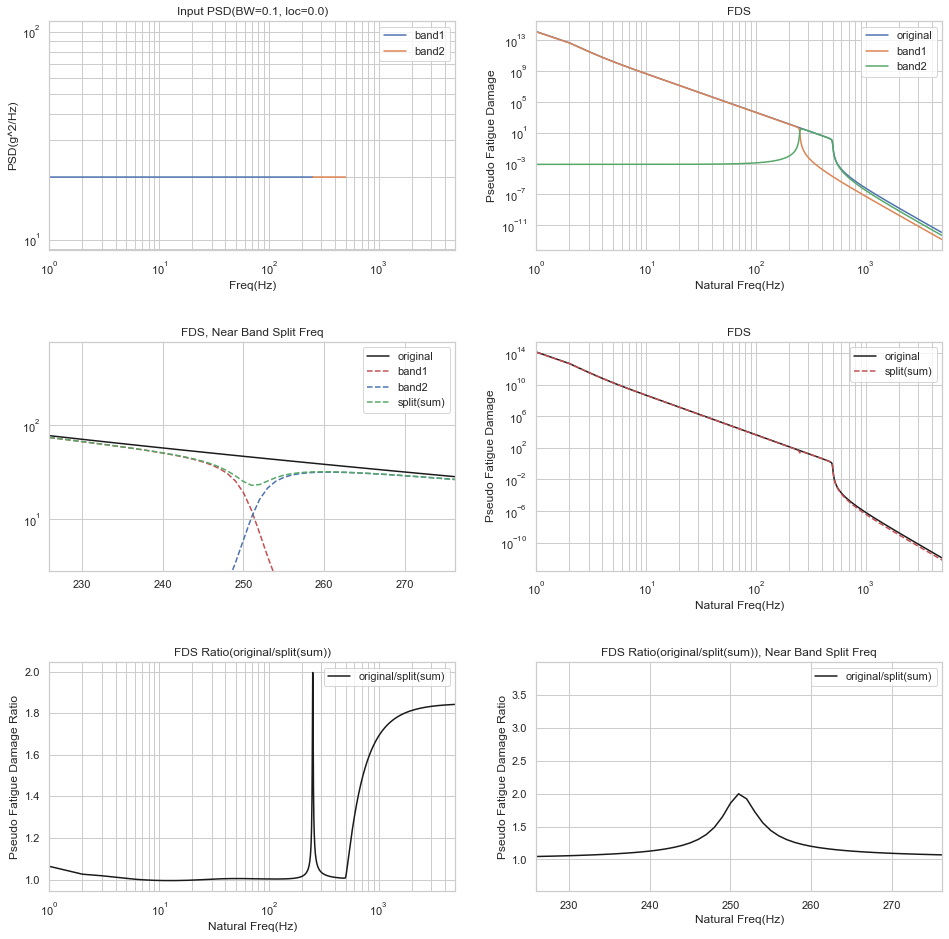

Error in callback <function flush_figures at 0x000001F44A0A0840> (for post_execute):


KeyboardInterrupt: 

In [15]:
for i in range(1,10):
    for j in range(11):
        # Generate Input PSD
        fmin = 1; fmax = 5000; bwp =i/10; loc = j/10;
        freq_spec,psd_spec = blwn(fmin,fmax,bwp,loc);
        # Band Split
        fi = np.linspace(min(freq_spec),max(freq_spec),5000);
        pi = log_interp(fi,freq_spec,psd_spec);
        dfi,dpi = band_split(fi,pi,2);
        # Calculate FDS
        fn,D = FDS_dirlik(fi,pi,zeta=0.01,m=4,T=1,C=1);
        fn,D1 = FDS_dirlik(dfi[0],dpi[0],zeta=0.01,m=4,T=1,C=1);
        fn,D2 = FDS_dirlik(dfi[1],dpi[1],zeta=0.01,m=4,T=1,C=1);
        # Plot
        plt.figure(figsize=(16,16));
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
        plt.subplot(321);
        plt.plot(dfi[0],dpi[0],label='band1'); plt.plot(dfi[1],dpi[1],label='band2'); plt.legend();
        plt.xscale('log'); plt.yscale('log'); plt.xlim(fmin,fmax); plt.title('Input PSD(BW=%.1f, loc=%.1f)'%(bwp,loc)); plt.xlabel('Freq(Hz)'); plt.ylabel('PSD(g^2/Hz)');
        plt.grid(b=True, which='both', linestyle='-');
        plt.subplot(322);
        plt.plot(fn,D,label='original'); plt.plot(fn,D1,label='band1'); plt.plot(fn,D2,label='band2'); 
        plt.xscale('log'); plt.yscale('log'); plt.legend(); plt.xlim(fmin,fmax);
        plt.title('FDS'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage');
        plt.grid(b=True, which='both', linestyle='-');
        plt.subplot(323);
        xlim1 = max(dfi[0])*0.9; xlim2 = min(dfi[1])*1.1;
        ylim1 = min(D[(fn>xlim1)&(fn<xlim2)])*0.1; 
        ylim2 = max(D[(fn>xlim1)&(fn<xlim2)])*10; 
        plt.plot(fn,D,'k-',label='original'); plt.plot(fn,D1,'r--',label='band1'); plt.plot(fn,D2,'b--',label='band2'); 
        plt.plot(fn,D1+D2,'g--',label='split(sum)');  plt.yscale('log');
        plt.legend(); plt.xlim(xlim1,xlim2); plt.ylim(ylim1,ylim2);
        plt.title('FDS, Near Band Split Freq');
        plt.grid(b=True, which='major', linestyle='-');
        plt.subplot(324);
        plt.plot(fn,D,'k-',label='original'); plt.plot(fn,D1+D2,'r--',label='split(sum)');  
        plt.xscale('log'); plt.yscale('log'); plt.legend(); plt.xlim(fmin,fmax);
        plt.title('FDS'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage');
        plt.grid(b=True, which='both', linestyle='-');
        plt.subplot(325);
        rD = D/(D1+D2);
        plt.plot(fn,rD,'k-',label='original/split(sum)');
        plt.legend(); plt.xlim(fmin,fmax);
        plt.xscale('log'); plt.title('FDS Ratio(original/split(sum))'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage Ratio');
        plt.grid(b=True, which='both', linestyle='-');
        plt.subplot(326);
        plt.plot(fn,rD,'k-',label='original/split(sum)');
        ylim1 = min(rD[(fn>xlim1)&(fn<xlim2)])*0.5; ylim2 = max(rD[(fn>xlim1)&(fn<xlim2)])*2;
        plt.grid(which='both'); plt.legend(); plt.xlim(xlim1,xlim2); plt.ylim(ylim1,ylim2);
        plt.title('FDS Ratio(original/split(sum)), Near Band Split Freq'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage Ratio');\
        plt.grid(b=True, which='both', linestyle='-');
        plt.savefig('BW%.1f_LOC%.1f_1d_4m.png'%(bwp,loc), dpi=300);  # Bandwidth, Location, 1% damping FDS, m = 4

In [ ]:
def bs_overlap(dfi,dpi,p): # 각 band의 데이터 수 x p(%) 만큼 overlap
    nb = len(dpi);
    ndata, pndata = np.zeros(nb,int),np.zeros(nb,int);
    dfi1 = np.copy(dfi); dpi1 = np.copy(dpi);
    for i in range(nb):
        ndata[i] = len(dpi[i]);
        pndata[i] = int(ndata[i]*p);
    for i in range(nb-1):
        dfi1[i] = np.concatenate([dfi[i],dfi[i+1][:pndata[i+1]+1]]);
        dpi1[i] = np.concatenate([dpi[i],dpi[i+1][:pndata[i+1]+1]]);
    for i in range(1,nb):        
        dfi1[i] = np.concatenate([dfi[i-1][-pndata[i]:],dfi1[i]]);
        dpi1[i] = np.concatenate([dpi[i-1][-pndata[i]:],dpi1[i]]);     
    return dfi1,dpi1

In [ ]:
dfi,dpi = bs_overlap(dfi,dpi,0.1); # 10 % overlap

In [ ]:
for i in range(1,10):
    for j in range(10):
        # Generate Input PSD
        fmin = 1; fmax = 5000; bwp =i/10; loc = j/10;
        freq_spec,psd_spec = blwn(fmin,fmax,bwp,loc);
        # Band Split
        fi = np.linspace(min(freq_spec),max(freq_spec),10000);
        pi = log_interp(fi,freq_spec,psd_spec);
        dfi,dpi = band_split(fi,pi,2);
        # Calculate FDS
        fn,D = FDS_dirlik(fi,pi,zeta=0.01,m=4,T=1,C=1);
        fn,D1 = FDS_dirlik(dfi[0],dpi[0],zeta=0.01,m=4,T=1,C=1);
        fn,D2 = FDS_dirlik(dfi[1],dpi[1],zeta=0.01,m=4,T=1,C=1);
        # Plot
        plt.figure(figsize=(16,16));
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
        plt.subplot(321);
        plt.plot(dfi[0],dpi[0],label='band1'); plt.plot(dfi[1],dpi[1],label='band2'); plt.legend();
        plt.xscale('log'); plt.yscale('log'); plt.xlim(fmin,fmax); plt.title('Input PSD(BW=%.1f, loc=%.1f)'%(bwp,loc)); plt.xlabel('Freq(Hz)'); plt.ylabel('PSD(g^2/Hz)');
        plt.grid(b=True, which='both', linestyle='-');
        plt.subplot(322);
        plt.plot(fn,D,label='original'); plt.plot(fn,D1,label='band1'); plt.plot(fn,D2,label='band2'); 
        plt.xscale('log'); plt.yscale('log'); plt.legend(); plt.xlim(fmin,fmax);
        plt.title('FDS'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage');
        plt.grid(b=True, which='both', linestyle='-');
        plt.subplot(323);
        xlim1 = max(dfi[0])*0.9; xlim2 = min(dfi[1])*1.1;
        ylim1 = min(D[(fn>xlim1)&(fn<xlim2)])*0.1; 
        ylim2 = max(D[(fn>xlim1)&(fn<xlim2)])*10; 
        plt.plot(fn,D,'k-',label='original'); plt.plot(fn,D1,'r--',label='band1'); plt.plot(fn,D2,'b--',label='band2'); 
        plt.plot(fn,D1+D2,'g--',label='split(sum)');  plt.yscale('log');
        plt.legend(); plt.xlim(xlim1,xlim2); plt.ylim(ylim1,ylim2);
        plt.title('FDS, Near Band Split Freq');
        plt.grid(b=True, which='major', linestyle='-');
        plt.subplot(324);
        plt.plot(fn,D,'k-',label='original'); plt.plot(fn,D1+D2,'r--',label='split(sum)');  
        plt.xscale('log'); plt.yscale('log'); plt.legend(); plt.xlim(fmin,fmax);
        plt.title('FDS'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage');
        plt.grid(b=True, which='both', linestyle='-');
        plt.subplot(325);
        rD = D/(D1+D2);
        plt.plot(fn,rD,'k-',label='original/split(sum)');
        plt.legend(); plt.xlim(fmin,fmax);
        plt.xscale('log'); plt.title('FDS Ratio(original/split(sum))'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage Ratio');
        plt.grid(b=True, which='both', linestyle='-');
        plt.subplot(326);
        plt.plot(fn,rD,'k-',label='original/split(sum)');
        ylim1 = min(rD[(fn>xlim1)&(fn<xlim2)])*0.5; ylim2 = max(rD[(fn>xlim1)&(fn<xlim2)])*2;
        plt.grid(which='both'); plt.legend(); plt.xlim(xlim1,xlim2); plt.ylim(ylim1,ylim2);
        plt.title('FDS Ratio(original/split(sum)), Near Band Split Freq'); plt.xlabel('Natural Freq(Hz)'); plt.ylabel('Pseudo Fatigue Damage Ratio');\
        plt.grid(b=True, which='both', linestyle='-');
        plt.savefig('BW%.1f_LOC%.1f_1d_4m_10ol.png'%(bwp,loc), dpi=300); # Bandwidth, Location, 1% damping FDS, m=4, 10% overlap